In [1]:
import pandas as pd
import numpy as np
import dtale
# import sweetviz as sv
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('G:/My Drive/IN/Data/Robyn/robyn_update.csv')
df.round(2)

,DATE,banner_I,blog_I,coupon_I,email_I,social_I,text_I,website_I,ecom_I,display_I,...,display_S,event_S,other_S,post_S,sweepstakes_S,mail_S,radio_S,circular_S,retailer_S,revenue
0,2019-10-05,62836886,11405123.0,183809663.0,NaN,5945479.0,NaN,146664.0,NaN,12600000.0,...,0.0,NaN,NaN,108489.42,513000.0,NaN,NaN,26955.29,2.772000e+05,8.977483e+07
1,2019-10-12,120592917,11405123.0,183809663.0,NaN,5945479.0,NaN,146664.0,NaN,12600000.0,...,0.0,NaN,379997.60,657371.26,513000.0,NaN,NaN,26955.29,7.572986e+05,1.119191e+08
2,2019-10-19,181801495,54811539.0,205679120.0,NaN,14945163.0,NaN,146664.0,NaN,12600000.0,...,0.0,82116.48,379997.60,664560.05,513000.0,NaN,NaN,26955.29,7.572986e+05,1.106076e+08
3,2019-10-26,206085547,59584985.0,214955960.0,456667.0,17167385.0,NaN,146664.0,NaN,12600000.0,...,0.0,120441.82,415348.35,705420.97,513000.0,NaN,NaN,26955.29,7.653936e+05,1.086742e+08
4,2019-11-02,886963849,505839713.0,833886179.0,16856395.0,17167385.0,NaN,146664.0,NaN,12600000.0,...,0.0,206420.41,415348.35,2683025.76,513000.0,1720000.0,NaN,26955.29,2.587007e+06,3.595164e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2021-04-17,164301683,3714622.0,7695819.0,2964073.0,15120000.0,NaN,NaN,NaN,2000000.0,...,0.0,NaN,NaN,74175.34,NaN,NaN,NaN,NaN,1.189420e+08,3.510714e+08
81,2021-04-24,164301683,3714622.0,7695819.0,2964073.0,15120000.0,NaN,NaN,NaN,2000000.0,...,0.0,NaN,NaN,74175.34,NaN,NaN,NaN,NaN,1.189420e+08,3.277938e+08
82,2021-05-01,160411811,3714622.0,4654091.0,2964073.0,15120000.0,NaN,NaN,NaN,2000000.0,...,0.0,NaN,NaN,74175.34,NaN,NaN,NaN,NaN,1.193764e+08,3.260223e+08
83,2021-05-08,63853937,3714622.0,413576.0,2964073.0,NaN,NaN,NaN,NaN,2000000.0,...,0.0,NaN,NaN,9500.00,NaN,NaN,NaN,NaN,1.191789e+08,3.114845e+08


In [3]:
# dtale.show(df) # there are quite a few more correlated variables with revenue, but nothing much about .5.

To give you a better impression of how much missing data there is, I provided the actual missing values, out of 146, the percentage of missing values, and the average of the percentage missing.

In [4]:
missing_values = df.isnull().sum()
print(missing_values)
print(np.average(missing_values))

DATE              0
banner_I          0
blog_I            2
coupon_I          7
email_I          16
social_I         10
text_I           67
website_I        49
ecom_I           71
display_I         8
event_I          32
other_I          30
post_I            0
sweepstakes_I    80
mail_I           50
radio_I          60
circular_I       10
retailer_I        0
banner_S          0
blog_S            2
coupon_S          7
email_S          16
social_S         10
text_S           67
website_S        49
ecom_S           71
display_S         8
event_S          32
other_S          30
post_S            0
sweepstakes_S    80
mail_S           50
radio_S          60
circular_S       10
retailer_S        0
revenue           0
dtype: int64
27.333333333333332


The average is 27, so any number 28 or above will have to be dropped, along with its matching spend or impressions. Otherwise, it could affect the imputation and therefore the correlation in Roybn prediction.

In [5]:
robyn_data = df.drop(['text_I', 'text_S', 'website_I', 'website_S', 'ecom_I', 'ecom_S', 'event_I',
                                'event_S', 'sweepstakes_I', 'sweepstakes_S', 'mail_I', 'mail_S', 'radio_I',
                                'radio_S', 'text_S', 'text_I', 'other_I', 'other_S'], axis=1)

Here I begin the process of imputing missing values. I have to split the date off for this method to work.

In [6]:
date_split = robyn_data[['DATE', 'revenue']]
imp_split = robyn_data.drop(['DATE', 'revenue'], axis=1)
col_names = list(imp_split.columns)
print(col_names)

['banner_I', 'blog_I', 'coupon_I', 'email_I', 'social_I', 'display_I', 'post_I', 'circular_I', 'retailer_I', 'banner_S', 'blog_S', 'coupon_S', 'email_S', 'social_S', 'display_S', 'post_S', 'circular_S', 'retailer_S']


In [7]:
i_vars = imp_split[['banner_I', 'blog_I', 'coupon_I', 'email_I', 'social_I', 'display_I', 'post_I',
                      'circular_I', 'retailer_I']]
i_stats = i_vars.describe()

In [8]:
# print(i_stats.iloc[4,:])
i_mean_25 = i_stats.iloc[4,:].mean()

In [9]:
# print(i_stats.iloc[6,:])
i_mean_75 = i_stats.iloc[6,:].mean()

In [10]:
s_vars = imp_split[['banner_S', 'blog_S', 'coupon_S', 'email_S', 'social_S', 'display_S', 'post_S',
                      'circular_S', 'retailer_S']]
s_stats = s_vars.describe()

In [11]:
# print(s_stats.iloc[4,:])
s_mean_25 = s_stats.iloc[4,:].mean()

In [12]:
# print(s_stats.iloc[6,:])
s_mean_75 = s_stats.iloc[6,:].mean()

In [13]:
i_vars.to_numpy().astype(np.int64)
s_vars.to_numpy().astype(np.int64)

array([[              247331,                90003,               447628,
        -9223372036854775808,                30000,                    0,
                      108489,                26955,               277200],
       [              442966,                90003,               447628,
        -9223372036854775808,                30000,                    0,
                      657371,                26955,               757298],
       [              648786,               339515,               558250,
        -9223372036854775808,                82633,                    0,
                      664560,                26955,               757298],
       [              721169,               370265,               553719,
                       14500,                94919,                    0,
                      705420,                26955,               765393],
       [             4247910,              3872465,              3023477,
                      894500,     

IterativeImputer is one of the newest imputation MLs out, and it is very resource intensive. It's imputations are supposed to be excellent, but you can only do so much with so much missing data.

In [14]:
i_it_imp = IterativeImputer(random_state=42, max_iter=15, initial_strategy='most_frequent', imputation_order='ascending',
                          min_value=i_mean_25, max_value=i_mean_75, verbose=2, sample_posterior=True)

In [15]:
s_it_imp = IterativeImputer(random_state=42, max_iter=15, initial_strategy='most_frequent', imputation_order='ascending',
                            min_value=s_mean_25, max_value=s_mean_75, verbose=2, sample_posterior=True)

In [16]:
i_it_imp.fit(i_vars)

[IterativeImputer] Completing matrix with shape (85, 9)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.07
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.10
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.12
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.15
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.17
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.20
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.23
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.26
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.29
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.32
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.34
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.36
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.39
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.43
[

IterativeImputer(initial_strategy='most_frequent', max_iter=15,
                 max_value=4977696830.222222, min_value=89808870.8888889,
                 random_state=42, sample_posterior=True, verbose=2)

In [17]:
imputed_i = i_it_imp.transform(i_vars)

[IterativeImputer] Completing matrix with shape (85, 9)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.01
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.06
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.07
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.08
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.09
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.09
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.10
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.11
[

In [18]:
s_it_imp.fit(s_vars)

[IterativeImputer] Completing matrix with shape (85, 9)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.07
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.13
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.16
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.20
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.23
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.26
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.30
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.33
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.36
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.39
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.43
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.46
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.49
[

IterativeImputer(initial_strategy='most_frequent', max_iter=15,
                 max_value=5436584.56, min_value=379813.80027777783,
                 random_state=42, sample_posterior=True, verbose=2)

In [19]:
imputed_s = s_it_imp.transform(s_vars)

[IterativeImputer] Completing matrix with shape (85, 9)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.05
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.06
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.07
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.08
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.10
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.26
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.27
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.28
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.29
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.30
[

I merged the dates back in, and as you can see, the missing values are gone, and they all look pretty reasonable. I'll repeat most of the tests I ran earlier to see if there's anything not obvious.

In [20]:
i_temp = pd.DataFrame(imputed_i)
s_temp = pd.DataFrame(imputed_s)

In [21]:
robyn_data = pd.concat([i_temp, s_temp], axis=1)
robyn_data = robyn_data.set_axis(col_names, axis=1)

In [22]:
robyn_data = pd.concat([robyn_data, date_split], axis=1)

In [23]:
dtale.show(robyn_data) # the revenue correlations look much more reasonable, but only banner spend breaking .5. Also, the power analysis doesn't reveal anything strange towards revenue.

In [31]:
temp_split = robyn_data.drop(['DATE'], axis=1)
vif_df = temp_split[~temp_split.isin([np.nan, np.inf, -np.inf]).any(1)]
X = vif_df
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

       feature         VIF
0     coupon_I   78.197550
1      email_I   67.279306
2     social_I   28.919790
3    display_I   74.185496
4       post_I    6.731160
5   circular_I   10.271085
6     coupon_S  128.889445
7      email_S   73.002617
8     social_S   18.646003
9    display_S   85.152050
10      post_S    9.933962
11  circular_S    4.117384
12     revenue   19.541916


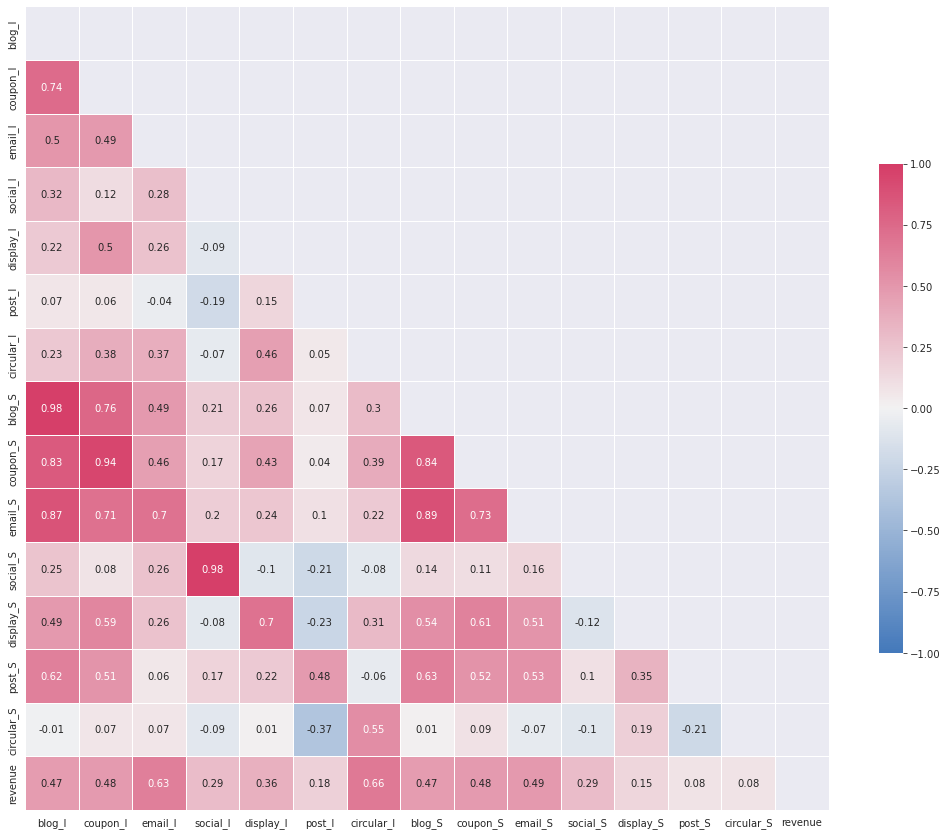

In [29]:
corr_vif = vif_df.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr_vif, dtype=bool))
plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr_vif, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
robyn_data = robyn_data.drop(['blog_I', 'blog_S'], axis=1)

In [33]:
robyn_data.to_csv('robyn_88.csv', index=False)